### Modeling
- Based on the train_basic_models function I decided to use lightgbm with 27 variables as a final model
- A hyperparamater optimization with hyperopt example is included in this notebook

In [1]:
import multiprocessing
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import src.features.modeling as feat_model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
train_path_processed = os.path.join("..", "data", "train_set_processed")

In [4]:
df = pd.read_csv(
    train_path_processed, sep=";", decimal=".", low_memory=False, compression="zip"
)

In [5]:
df.dtypes.value_counts()

int64      294
float64      3
dtype: int64

### Train basic models

In [7]:
# split the dataset for cross validation
y = df["toon_churn"]
X = df.drop("toon_churn", axis=1)

In [8]:
# create different feature sets to compare performance accross data complexity
features_list = []
features_list.append(list(X.columns))

for i in np.arange(2, 5):
    file = f"combined_list_{i}_votes"
    path = os.path.join("..", "feature_lists", file)
    temp_list = list(pd.read_csv(path, sep=";", encoding="utf-8")["features"])
    features_list.append(temp_list)

In [10]:
for feature_set in features_list:
    X = df[feature_set]
    with pd.option_context("display.width", 1000):
        print(f"Results based on {len(feature_set)} variables:")
        print(feat_model.train_basic_models(X, y))
        print("-" * 120)

Results based on 296 variables:
               classifier  mean_fit_time  sum_rank  avg_accuracy  avg_f1  avg_roc_auc
4          LGBMClassifier         14.818         3         0.890   0.885        0.957
2           XGBClassifier         77.130         6         0.881   0.874        0.948
1      LogisticRegression          4.360        10         0.875   0.869        0.933
0  RandomForestClassifier         13.286        12         0.872   0.859        0.945
5               LinearSVC         71.157        14         0.868   0.860        0.926
3           SGDClassifier          7.253        18         0.862   0.856        0.916
------------------------------------------------------------------------------------------------------------------------
Results based on 146 variables:
               classifier  mean_fit_time  sum_rank  avg_accuracy  avg_f1  avg_roc_auc
4          LGBMClassifier          7.995         3         0.890   0.885        0.956
2           XGBClassifier         39.282 

#### Notes modeling
- Go with the LGBMclassifier with only 27 variables
- Due to the relative high out of the box accuracy I want to check the independent variables once more on hidden obvious relationships with toon churn
- Variables like 'auto_bezig_geen_ind' and 'ntal_kind_in_huis_geen_ind' are confusing due to the addition of 'geen', not immediately obvious how to interpret

In [11]:
print(features_list[3])

['ele_bron_ecostroom_ind', 'ele_bron_wind_eu_ind', 'ele_vbr_prf_1b_ind', 'gas_klant_ind', 'gas_lpt_4jr_ind', 'gas_type_prijs_vast_ind', 'vzgebied_stedin_buiten_ind', 'woon_eigendom_koop_ind', 'ntal_kind_in_huis_geen_ind', 'ntal_volwassen_in_huis_1_ind', 'ntal_volwassen_in_huis_2_ind', 'postorder_koper_ind', 'auto_bezit_geen_ind', 'auto_bezit_eigen_ind', 'bezit_spelcomputer_ind', 'web_activit_zeer_veel_ind', 'btwz_onbekend_ind', 'incgrp_medium_risk_ind', 'incgrp_low_risk_ind', 'contact_lst_jr_aant_freq', 'cont_kcm_soort_service_freq', 'sale_lstjr_knl_last_inb_ind', 'web_url_app_lst_jr_ind', 'web_url_meterstnden_lst_jr_ind', 'web_url_verhuizen_lst_jr_ind', 'days_since_ltst_sale_num', 'klant_jr_sinds_frst_start_rec']


In [14]:
for feature in features_list[3]:
    print(
        pd.crosstab(df["toon_churn"], df[feature]).assign(
            perc_churn=lambda x: x[1] / np.sum(x, axis=1)
        )
    )

ele_bron_ecostroom_ind      0      1  perc_churn
toon_churn                                      
0                       12622  10270    0.448628
1                       18877   4027    0.175821
ele_bron_wind_eu_ind      0     1  perc_churn
toon_churn                                   
0                     18101  4791    0.209287
1                     20033  2871    0.125349
ele_vbr_prf_1b_ind      0      1  perc_churn
toon_churn                                  
0                    9837  13055    0.570287
1                   16547   6357    0.277550
gas_klant_ind      0      1  perc_churn
toon_churn                             
0               4957  17935    0.783461
1              15509   7395    0.322869
gas_lpt_4jr_ind      0     1  perc_churn
toon_churn                              
0                16034  6858    0.299581
1                20414  2490    0.108715
gas_type_prijs_vast_ind      0      1  perc_churn
toon_churn                                       
0               

KeyError: 1.0

### Hyperopt
- More information on hyperopt can be found at https://github.com/hyperopt/hyperopt
- LightGBM needs integers instead of floats as input hyperparamters, now fixed with choice .. but what is the difference with
quniform?
- https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html for reasoning behind the hyperparameters

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1337
)

In [16]:
import hyperopt.pyll.stochastic
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

In [17]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(LGBMModel, sklearn.base.ClassifierMixin)
 |  LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.ClassifierMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', cate

In [18]:
def hyperopt_lgbm(params):
    clf = LGBMClassifier(n_jobs=-1, **params)
    return cross_val_score(clf, X_train, y_train).mean()


def f(params):
    acc = hyperopt_lgbm(params)
    return {"loss": -acc, "status": STATUS_OK}


space4rf = {
    "num_leaves": hp.choice("num_leaves", range(3, 15, 1)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.005), np.log(0.5)),
    "min_child_samples": hp.choice("min_child_samples", range(10, 50, 2)),
}

In [19]:
# Examples of combinations of hyperparameters
for i in range(10):
    print(hyperopt.pyll.stochastic.sample(space4rf))

{'learning_rate': 0.3600879853332521, 'min_child_samples': 12, 'num_leaves': 12}
{'learning_rate': 0.14151502745670336, 'min_child_samples': 32, 'num_leaves': 13}
{'learning_rate': 0.36258742695925333, 'min_child_samples': 46, 'num_leaves': 13}
{'learning_rate': 0.05144306551790792, 'min_child_samples': 12, 'num_leaves': 8}
{'learning_rate': 0.11366819771479061, 'min_child_samples': 46, 'num_leaves': 11}
{'learning_rate': 0.009922120419382705, 'min_child_samples': 26, 'num_leaves': 14}
{'learning_rate': 0.046402929423903665, 'min_child_samples': 32, 'num_leaves': 6}
{'learning_rate': 0.026016596472649846, 'min_child_samples': 48, 'num_leaves': 3}
{'learning_rate': 0.26866722433142964, 'min_child_samples': 24, 'num_leaves': 6}
{'learning_rate': 0.09309247936460935, 'min_child_samples': 44, 'num_leaves': 4}


### The out of the box score = 0.881
- this is still a simple set-up which we will expand in the future

In [21]:
trials = Trials()
best = fmin(fn=f, space=space4rf, algo=tpe.suggest, max_evals=500, trials=trials)
print("best:", best)

100%|██████████████████████████████████████████| 500/500 [17:10<00:00,  2.06s/trial, best loss: -0.8812095397891271]
best: {'learning_rate': 0.14160113871959173, 'min_child_samples': 7, 'num_leaves': 11}


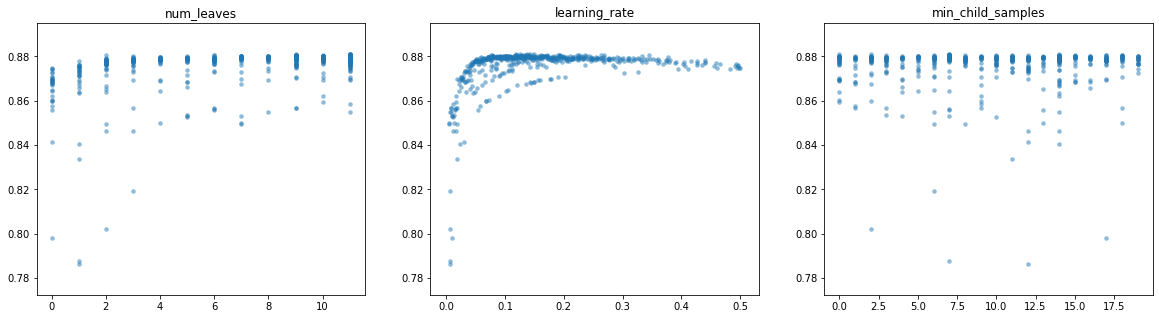

In [22]:
parameters = ["num_leaves", "learning_rate", "min_child_samples"]
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 5))

cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t["misc"]["vals"][val] for t in trials.trials]).ravel()
    ys = [-t["result"]["loss"] for t in trials.trials]
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5)
    axes[i].set_title(val)

### Create final model

In [23]:
lightgbm = LGBMClassifier(
    learning_rate=0.14, min_child_samples=7, num_leaves=11, n_jobs=-1
)

In [24]:
lightgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.14, max_depth=-1,
               min_child_samples=7, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=11, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [25]:
lightgbm_pred = lightgbm.predict(X_val)

In [26]:
print(confusion_matrix(lightgbm_pred, y_val))
print(classification_report(lightgbm_pred, y_val))

[[4266  768]
 [ 308 3818]]
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      5034
           1       0.83      0.93      0.88      4126

    accuracy                           0.88      9160
   macro avg       0.88      0.89      0.88      9160
weighted avg       0.89      0.88      0.88      9160



#### model diagnostics
- pretty decent for out of the box modeling

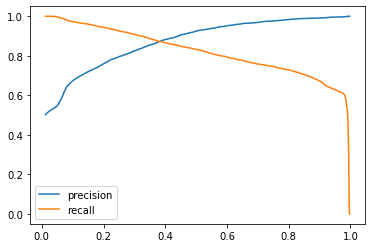

In [27]:
feat_model.plot_recall_precision(lightgbm, X_val, y_val)

Currently at iteration 100 of 36000
Currently at iteration 5100 of 36000
Currently at iteration 10100 of 36000
Currently at iteration 15100 of 36000
Currently at iteration 20100 of 36000
Currently at iteration 25100 of 36000
Currently at iteration 30100 of 36000
Currently at iteration 35100 of 36000


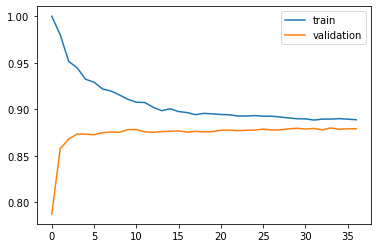

In [28]:
feat_model.underfit_overfit(lightgbm, X_train, y_train, X_val, y_val)

### Model export
- Included date for references

In [30]:
from datetime import datetime

In [51]:
file = datetime.now().strftime("%Y%m%d") + "_lightgbm_" + str(X.shape[0]) + "_rows"

In [53]:
model_path = os.path.join("..", "models", file)

In [54]:
model_path

'..\\models\\20200304_lightgbm_45796_rows'

In [55]:
pickle.dump(lightgbm, open(model_path, "wb"))